Cleaned up path planning changed by Alicja

In [4]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, LineString, MultiLineString
import geopandas as gpd
import numpy as np
import pandas as pd
import math
from dubins_curves import *

Alicja's version of loading the data

In [5]:
def read_field(file_name: str):
    """
    Given a json file name, extract the geometric shape of the field (with holes) and plot it.
    """

    with open("/".join(["./data/field_geometry", file_name])) as json_file:
        json_data = json.load(json_file) # or geojson.load(json_file)

    # list with the coordinates for each polygon like [[polygon1_coords],[polygon2_coords],....] where polygon1_coords looks like this: [[x1,y1],[x2,y2],......]
    coordinates = []
    for i in range(len(json_data['features'])):
        coordinates.append(json_data['features'][i]['geometry']['coordinates'])
   
    # first polygon is always the field, the rest (if it exists) is the obstacles
    field = gpd.GeoSeries(Polygon(coordinates[0][0]))

    if len(coordinates) > 1:  # if there are any obstacles
        obstacles = [gpd.GeoSeries(Polygon(coordinates[i+1][0])) for i in range(len(coordinates)-1)]
        # make a hole in the field by subtracting the objects
        for obstacle in obstacles:
            field = field.symmetric_difference(obstacle)

    # plot the field
    field.plot(color = 'green')

    return field


Hidde's version of loading the data

In [183]:
def load_data(filepath,include_obstacles = False):
    """
    function to load json file and create polygon object

    args:
        filepath (str): filepath that contains the json file to be parsed
        include_obstacles (bool): boolean to indicate if you want to include the obstacles in the resulting field (will probably be usefull for some debugging)

    returns:
        field (geopandas Geoseries)

    """
    # This cell opens the json file that contains field geometry
    with open(filepath) as json_file:
        json_data = json.load(json_file) # or geojson.load(json_file)

    # This cell parses the json data and obtains a list with the coordinates for each polygon like
    # [[polygon1_coords],[polygon2_coords],....]
    # where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
    coordinates = []
    polygons = []
    for i in range(len(json_data['features'])):
        coordinates.append(json_data['features'][i]['geometry']['coordinates'])
        polygons.append(gpd.GeoSeries(Polygon(coordinates[i][0])))
    
    field = polygons[0]
    if include_obstacles:
        for i in range(1,len(polygons)):
            field = field.symmetric_difference(polygons[i])

    return field

### The rest of the functions.
Function interpolate_path still needs to be corrected

In [269]:

def generate_headlands(field,size):
    field_with_headlands = field.buffer(-size)
    return field_with_headlands
        

def linefromvec(vec):
    """
    turn a vector into a line in 2d with a slope and intercept
    attrs:
        vec (array): 2x2 array with x,y coords of begin point in first row, x,y coords of end point in second row
    returns:
        slope (float): slope of the resulting line, unless it is vertical - then None
        intercept (float): y-intercept of the resulting line, unless it is vertical - then x-intercept
    """

    if vec[1][0]-vec[0][0] == 0: # if the line is vertical, the y-intercept and slope don't exist
        slope = None
        intercept = vec[0][0] # store the x-intercept instead of the y-intercpet
    else:
        slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0]) # if the line is horizontal, the slope is 0
        intercept = vec[1][1]-vec[1][0]*slope 
    return slope, intercept


def edge_to_line(coordinates):
    """
    turn a df of field coordinates into a df with the slopes and intercepts of all edges of the field
    attrs:
        coordinates (geopandas DataFrame): a GeoPandas Dataframe containing the xy coordinates of all points that describe a polygon. Can be obtained using the get_coordinates() method
    returns:
        edge_lines (pandas DataFrame): a Pandas DF that contains slopes and intercepts of all lines describing the outline of a polygon
    
    """
    
    edge_lines = pd.DataFrame(columns=['slope', 'intercept'])
                              
    for edge in range(len(coordinates)-1):
        x_begin = coordinates.iloc[edge]['x']
        x_end = coordinates.iloc[edge+1]['x']
        y_begin = coordinates.iloc[edge]['y']
        y_end = coordinates.iloc[edge+1]['y']
        vector = np.array([[x_begin,y_begin],[x_end,y_end]])
        slope,intercept = linefromvec(vector)
        edge_lines = pd.concat([edge_lines, pd.DataFrame([[slope, intercept]], columns=['slope', 'intercept'])], ignore_index=True)
    
    return edge_lines
             
def basis_AB_line(edge,coordinates):  
    """
    Creates an AB line to be used as basis for filling the field, the AB line has the same orientation as the given edge  
        and the length of the AB line is such that it covers the entire y-range of the field

    attrs:
        edge (Pandas Series): a slice of a dataframe containing the edge information, with the slope and intercept information of the 
                                edge for which you want to create a base AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon

    returns:   
        base_AB (numpy array): a line object that covers the entire y-range of the polygon with a direction
                                        specified in the edge attribute
    """
    slope = edge['slope']
    intercept = edge['intercept']
    xmin = min(coordinates['x'])
    xmax = max(coordinates['x'])
    ymin = min(coordinates['y'])
    ymax = max(coordinates['y'])

    if pd.isna(slope): # for vertical lines 
        base_AB = np.array([[intercept, ymin],[intercept, ymax]]) #edge x-coord stay the same, y stretches to ymin and ymax
    else: 
        if slope > 0:
            x_1 = min(xmin, (ymin-intercept)/slope)
            x_2 = max(xmax, (ymax-intercept)/slope)
        elif slope == 0:
            x_1 = xmin
            x_2 = xmax  
        elif slope < 0:
            x_1 = min(xmin, (ymax-intercept)/slope)
            x_2 = max(xmax, (ymin-intercept)/slope)
        y_1 = x_1*slope+intercept   
        y_2 = x_2*slope+intercept
        base_AB = np.array([[x_1, y_1],[x_2, y_2]])

    return base_AB, slope

def fill_field_AB(base_AB,slope,coordinates,distance):
    """
    takes the base AB line, its slope and a distance between lines and fills the field with AB lines of a given angle
    attrs:
        base_AB (array): array with xy coordinates of beginning and end points of the base vector
        slope (float): the slope of the basis AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon
        d (float): distance between two AB lines

    returns:
        swath_list (list): a list containing Geoseries objects of different AB-lines
    """
    
    # Initialize empty lists that will contain geoseries objects
    swath_list = []

    # Determine amount of AB-lines that are needed if they are not horizontal
    xmax = max(coordinates['x'])
    xmin = min(coordinates['x'])
    nr_passes = int((xmax-xmin)//distance + 2)

    if pd.isna(slope): # vertical AB-lines
        dx = distance
        for i in range(-nr_passes,nr_passes):
            swath_list.append(gpd.GeoSeries(LineString([[base_AB[0][0]+dx*i,base_AB[0][1]],[base_AB[1][0]+dx*i,base_AB[1][1]]])))
    else:
        theta = np.arctan(slope) # angle of AB line wrt x-axis
        if theta == 0 : # horizontal AB line
            dy = distance # use y-offset for horizontal lines
            # Determine amount of AB-lines that are needed for horizontal lines
            ymax = max(coordinates['y'])
            ymin = min(coordinates['y'])
            nr_passes = int((ymax-ymin)//distance + 2)
            # update the list of AB-lines 
            for i in range(-nr_passes,nr_passes):
                swath_list.append(gpd.GeoSeries(LineString([[base_AB[0][0],base_AB[0][1]+dy*i],[base_AB[1][0],base_AB[1][1]+dy*i]])))
        else:
            dx = distance/np.sin(theta) # use the angle and parameter d to calculate x-offset between swaths
            for i in range(-nr_passes,nr_passes):
                swath_list.append(gpd.GeoSeries(LineString([[base_AB[0][0]+dx*i,base_AB[0][1]],[base_AB[1][0]+dx*i,base_AB[1][1]]])))

    return swath_list

def clip_swaths(swath_list,field):
    """
    function to clip swaths to the headlands
    attrs:
        swath_list (list): List of geoseries objects that describe the generated swaths
        field (geopandas Geoseries): Geoseries object that describes the field geometry

    returns:
        swaths_clipped_nonempty (list): a list of geoseries objects that contains the clipped swaths that are not empty
    """
    swaths_clipped = []
    for i in range(len(swath_list)):
        swaths_clipped.append(gpd.clip(swath_list[i],field))
        swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
        swaths_type = [type(swath[0]) for swath in swaths_clipped_nonempty]
    if len(swaths_clipped_nonempty) == 0:
        raise Exception('No swaths were generated, something went wrong with clipping')
    if MultiLineString in swaths_type:
        raise Exception('Field is not convex for this shape')
    return swaths_clipped_nonempty


def generate_path(swaths_clipped_nonempty, turning_rad):

    line = []

    for i in range(len(swaths_clipped_nonempty)-1):
        line1 = swaths_clipped_nonempty[i]
        line2 = swaths_clipped_nonempty[i+1]
        line1_coords = line1.get_coordinates()
        line2_coords = line2.get_coordinates()
        
        diff = line1_coords.iloc[0]-line1_coords.iloc[1]
        if diff['x'] == 0: # the line is vertical
            heading1 = 90
        else:
            heading1 = math.degrees(math.atan(diff['y']/diff['x']))

        heading2 = heading1

        if i%2 != 0:
            heading1 += 180
        else:
            heading2 += 180

        index = (i+1)%2

        pt1 = (line1_coords.iloc[index]['x'],line1_coords.iloc[index]['y'],90-heading1)
        pt2 = (line2_coords.iloc[index]['x'],line2_coords.iloc[index]['y'],90-heading2)
        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        line.append(gpd.GeoSeries((line1[0])))
        line.append(gpd.GeoSeries(curve1))
    line.append(gpd.GeoSeries(line2[0]))

    return line


def interpolate_path(path,distance):
    """
    Function to interpolate the straight line segments of the path (otherwise they are simply a beginning and endpoint)
    args:
        path (list): list of geopandas Geoseries objects that describe the path
        distance (float): distance between interpolated points

    returns:
        path (list): list of geopandas Geoseries objects that has the same length as the input, 
                        but each straight line segment is split into more pieces
    """

    for i in range(len(path)): # Loop over the list of path segments
        if i%2 == 0: # We always start the path with a straight line, and then turns and straight lines alternate, so each even entry in the list is a straight line segment
            if i%4 ==0: # Every second straight line segment has to be reversed; each vector has the same direction, but the tractor
                        #should drive back and forth, so each 4th element in the row (every second straight path) reversed and then interpolated
                line = path[i][0]
                distances = np.arange(0,line.length,distance)
                interpolated_path = LineString([line.interpolate(distance) for distance in distances])
                path[i] = gpd.GeoSeries(interpolated_path)
            else:
                line = path[i][0]
                distances = np.arange(line.length,0,-distance)
                interpolated_path = LineString([line.interpolate(distance) for distance in distances])
                path[i] = gpd.GeoSeries(interpolated_path)
        else: # Don't do anything if we have an odd index, those correspond to turns which are already interpolated. 
            continue
    return path
        
def path_to_df(best_path):
    """
    generates a df with the coordinates from the best path

    args:
        best_path (list): a list of linestring objects that define a path

    returns: 
        df_best_path (pandas DataFrame): a dateframe with x and y coordinates of the best path
    """
    
    df = pd.concat([x.get_coordinates() for x in best_path])
    df_best_path = df.set_index((np.arange(len(df))))
    return df_best_path

### The main function.

In [235]:
def pathplanning(data_path,include_obs,turning_rad,distance,plotting,headland_size, interpolation_dist):
    """
    main function for the pathplanning, loads the data and generates a path (maybe its better to make this a class but idk)
    
    args:
        data_path (str): filepath that contains the json file to be parsed
        include_obs (bool): boolean to indicate if you want to include the obstacles in the 
                            resulting field (will probably be usefull for some debugging)
        turning_rad (float): turning radius of the tractor in m
        distance (float): distance between swaths in m
        plotting (bool): boolean to decide whether you want to plot the generated path or not
        headland_size (float): size of the headlands in m
        interpolation_dist (float): the distance between points in the straight line segment

    returns:
        field (geopandas Geoseries): The polygon that defines the field
        best_path (pandas DataFrame): Dataframe containing the xy coordinates of each checkpoint of the path. 

    """
    field = load_data(data_path,include_obs) 
    field_headlands = generate_headlands(field,headland_size)
    coordinates = field_headlands.get_coordinates()
    lines = edge_to_line(coordinates)
    
    # Initialize emtpy lists to contain the generated paths and path lengths
    paths = [] 
    path_lengths = []

    for i in range(len(coordinates)-1): # Loop over all of the edges
        print('Finding path {}/{}'.format(i,len(coordinates)-1))
        try:
            # Calculate the basis AB line, use that to fill the field and clip the swaths
            line,slope = basis_AB_line(lines.iloc[i],coordinates)
            swath_list = fill_field_AB(line,slope,coordinates,distance)
            swaths_clipped = clip_swaths(swath_list,field_headlands)
            # Make a path with dubins curves
            path = generate_path(swaths_clipped,turning_rad)
            # Interpolate the path with some specified distance
            path = interpolate_path(path,interpolation_dist)
            paths.append(path)
            # Calculate path lenght as a measure of how good a path is, this should be replaced with a different measure
            total_len = 0
            for i in range(len(path)):
                total_len+= path[i].length.item()
            path_lengths.append(total_len)
        except Exception as error: # Error handling to make sure the loop continues if an error pops up
            paths.append(None)
            path_lengths.append(0)
            print(error)
            continue

    # Finding the path with the best measure
    best_path_index = np.argmax(path_lengths)
    best_path = paths[best_path_index]
    # Converting path to df
    best_path = path_to_df(best_path)

    # Plot the path if it is specified
    if plotting:
        fig, ax = plt.subplots()
        field.plot(ax = ax,color = 'g')
        field_headlands.boundary.plot(ax = ax,color = 'r')
        best_path.plot(x = 'x', y = 'y',ax = ax,color = 'magenta')
        plt.show()
    
    return field,best_path

C:\Users\20191441\AppData\Local\Temp\ipykernel_3124\2384404233.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_lines = pd.concat([edge_lines, pd.DataFrame([[slope, intercept]], columns=['slope', 'intercept'])], ignore_index=True)


Finding path 0/4
IllegalArgumentException: point array must contain 0 or >1 elements

Finding path 1/4
Finding path 2/4
single positional indexer is out-of-bounds
Finding path 3/4


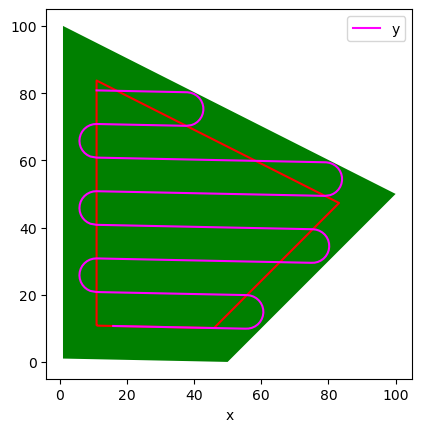

In [270]:
data_path ="./data/field_geometry/test_2.json"
include_obs = False
turning_rad = 5
distance = 10
field, best_path = pathplanning(data_path,include_obs,turning_rad,distance,True,10,5)

C:\Users\20191441\AppData\Local\Temp\ipykernel_3124\2384404233.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_lines = pd.concat([edge_lines, pd.DataFrame([[slope, intercept]], columns=['slope', 'intercept'])], ignore_index=True)


Field is not convex for this shape


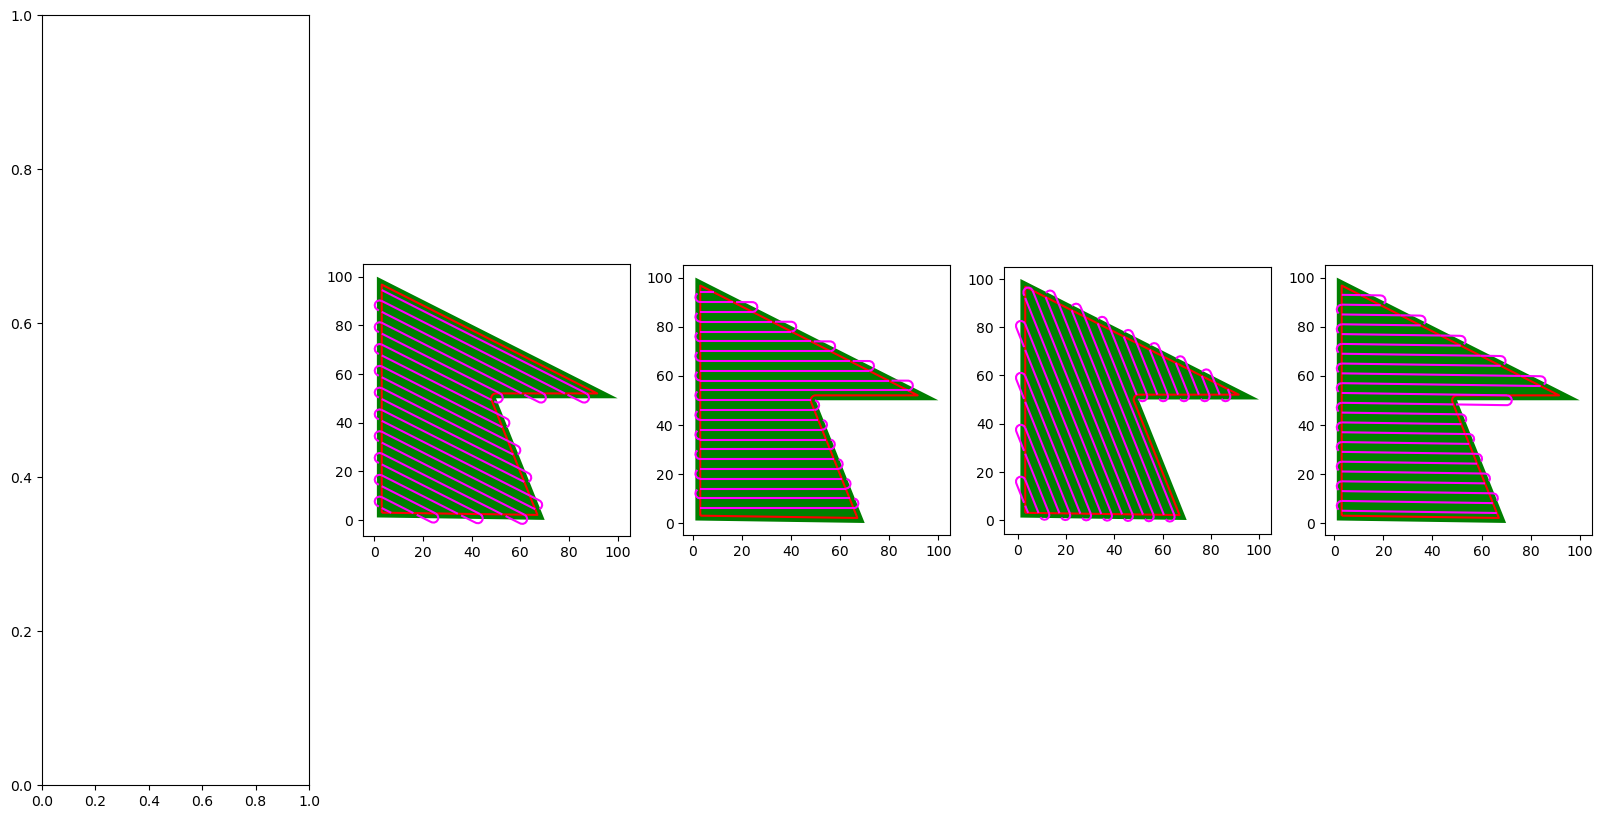

In [272]:
data_path ="./data/field_geometry/test_4.json"
turn_radius = 2
dist = 4


field = load_data(data_path,include_obs) 
field_headlands = generate_headlands(field,2)
coordinates = field.get_coordinates()
lines = edge_to_line(coordinates)


fig, ax = plt.subplots(1, len(coordinates)-1, figsize = (20, 10))

for i in range(len(coordinates)-1): # Loop over all of the edges
    try:
        # Calculate the basis AB line, use that to fill the field and clip the swaths
        line,slope = basis_AB_line(lines.iloc[i],coordinates)
        swath_list = fill_field_AB(line,slope,coordinates,dist)
        swaths_clipped = clip_swaths(swath_list,field_headlands)
        # Make a path with dubins curves
        #path = path_to_df(generate_path(swaths_clipped,5))
        line = generate_path(swaths_clipped,turn_radius)

        field.plot(ax = ax[i], color = 'green')
        field_headlands.boundary.plot(ax = ax[i],color = 'red')
        #ax[i].plot([1,1],[1,1])
        #path.plot(x = 'x', y = 'y', ax = ax[i], color = 'magenta')
        for j in range(len(line)):
            line[j].plot(ax = ax[i], color = 'magenta')
    except Exception as error:
        print(error)
   

    

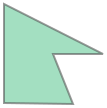

In [247]:
field[0]

In [266]:
a = LineString([[60,-10],[60,150]])
a_df = gpd.GeoSeries(a)
clipped = gpd.clip(a_df,field)
type(clipped[0])==MultiLineString

True

In [268]:
4 in [1,1,1,2]

False